# 누적관객수 Top 11 영화들에 대한 각종 점유율 분석

## 필요 패키지

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from datetime import date
import os

## 데이터 파일 불러오기 및 전처리

In [2]:
# 이용하는 함수 모음 클래스
class movie_functions():
    movies = []
    file_names = os.listdir("./data/top11_screen")

    # 파일 불러오는 함수
    def get_file(self):
        for file_name in self.file_names:
            # 엑셀 파일 불러오기
            temp = pd.read_excel(f"./data/top11_screen/{file_name}")
            # 컬럼명 재설정 및 쓸데없는 행 제거
            temp.columns = temp.loc[2,:]
            temp.columns.name = file_name[0:-4]
            temp.drop([0,1,2], inplace=True)
            temp.reset_index(drop=True, inplace=True)
            # 날짜 컬럼에서 시간 제거
            for i in range(len(temp)):
                temp.loc[i,"날짜"] = temp.loc[i,"날짜"].date()
            # 영화 리스트에 추가
            self.movies.append(temp)
    
    # 개봉년도와 그 다음년도 이후의 데이터는 재개봉으로 판단하여 제외하는 함수
    def remove_outlier_year(self, df):
        overindex= []
        for i in range(len(df)):
            if (df.loc[i, "날짜"].year <= (df.loc[0, "날짜"].year + 1)):
                overindex.append(i)
        df = df.loc[overindex,:]
        return df
    
    def remove_year(self):
        for i in range(len(self.movies)):
            self.movies[i] = self.remove_outlier_year(self.movies[i])

    # 스크린수가 100개 미만인 경우는 전체 누적관객수에 영향이 거의 없으므로 제외하는 함수
    def remove_under100(self):
        for i in range(len(self.movies)):
            self.movies[i] = self.movies[i].loc[self.movies[i]["스크린수"] > 100,:]
            self.movies[i].reset_index(drop=True, inplace=True)

    # 점유율들을 100퍼센트 기준으로 변경하기
    def update_shares(self):
        for i in range(len(self.movies)):
            for col in ["스크린점유율", "상영점유율", "좌석점유율", "좌석판매율"]:
                self.movies[i].loc[:,col] = 100 * self.movies[i].loc[:,col]
    
    # 관객수, 매출액 증감 새로운 파생컬럼으로 나누기
    def create_increase_column_sub(self, df):
        for i in range(len(df)):
            df.loc[i,"매출액증감(전일대비)비율"] = float(df.loc[i,"매출액증감(전일대비)"].split()[2][:-1])
            df.loc[i,"매출액증감(전일대비)"] = int(df.loc[i,"매출액증감(전일대비)"].split()[0])
        for i in range(len(df)):
            df.loc[i,"관객수증감(전일대비)비율"] = float(df.loc[i,"관객수증감(전일대비)"].split()[2][:-1])
            df.loc[i,"관객수증감(전일대비)"] = int(df.loc[i,"관객수증감(전일대비)"].split()[0])
        return df
    
    def create_increase_column(self):
        for i in range(len(self.movies)):
            self.movies[i] = self.create_increase_column_sub(self.movies[i])

    # 스크린수 대비 관객수 컬럼 생성
    def create_ratio_sub(self, df):
        df.loc[:,"스크린수대비관객수"] = df.loc[:,"관객수"] / df.loc[:,"스크린수"]
        df.loc[:,"좌석수대비관객수"] = df.loc[:,"관객수"] / df.loc[:,"좌석수"]
        df.loc[:,"스크린점유율대비관객수"] = df.loc[:,"관객수"] / df.loc[:,"스크린점유율"]
        return df

    def create_ratio(self):
        for i in range(len(self.movies)):
            self.movies[i] = self.create_ratio_sub(self.movies[i])

    # 직선 그래프 그리는 함수
    def lineplotting(self, column, show_movies=[]):
        if show_movies == []:
            show_movies = [df.columns.name for df in self.movies]
            title_movie = "Top11 영화"
        else:
            title_movie = show_movies[0]
            for i in range(len(show_movies)-1):
                title_movie = title_movie + ", " + show_movies[i+1]
            title_movie = title_movie + " 영화"
        show_movies = list(np.sort(show_movies))
        plt.rcParams['font.family'] = 'Malgun Gothic'
        fig = plt.figure(figsize=(20,10))
        ax1 = fig.add_subplot(1,1,1)
        for i in range(len(self.movies)):
            if self.movies[i].columns.name in show_movies:
                sns.lineplot(self.movies[i].index, self.movies[i][column], ax = ax1)
        plt.legend(show_movies)
        plt.title(f"{title_movie}들의 개봉기간 동안의 {column}")
        plt.savefig(f"./data/plot/{title_movie}_{column}.jpg")
        plt.show()


In [3]:
aaa = ["aa1", "bb2"]
aa_str = aaa[0]
aa_str = aa_str + ", " + aaa[1]

In [4]:
# 클래스 선언 및 파일 불러오기
mf = movie_functions()
mf.get_file()

In [5]:
# 각각 NA값 확인
for i in range(len(mf.movies)):
    print(f"{mf.movies[i].columns.name}:{mf.movies[i].isna().sum().sum()}")

7번방의선물:0
광해:0
극한직업:0
기생충:0
도둑들:0
명량:0
베테랑:0
부산행:0
신과함께-인과연:0
암살:0
택시운전사:0


In [6]:
# 필요없는 년도 제외하기
mf.remove_year()

In [7]:
# 스크린수 100개 이하 제외하기
mf.remove_under100()

In [8]:
# 점유율 100퍼센트 단위로 바꾸기
mf.update_shares()

In [9]:
# 증감에 대한 파생컬럼 생성하기
mf.create_increase_column()

In [10]:
# 스크린수, 좌석수, 스크린점유율 대비 관객수 컬럼 생성
mf.create_ratio()

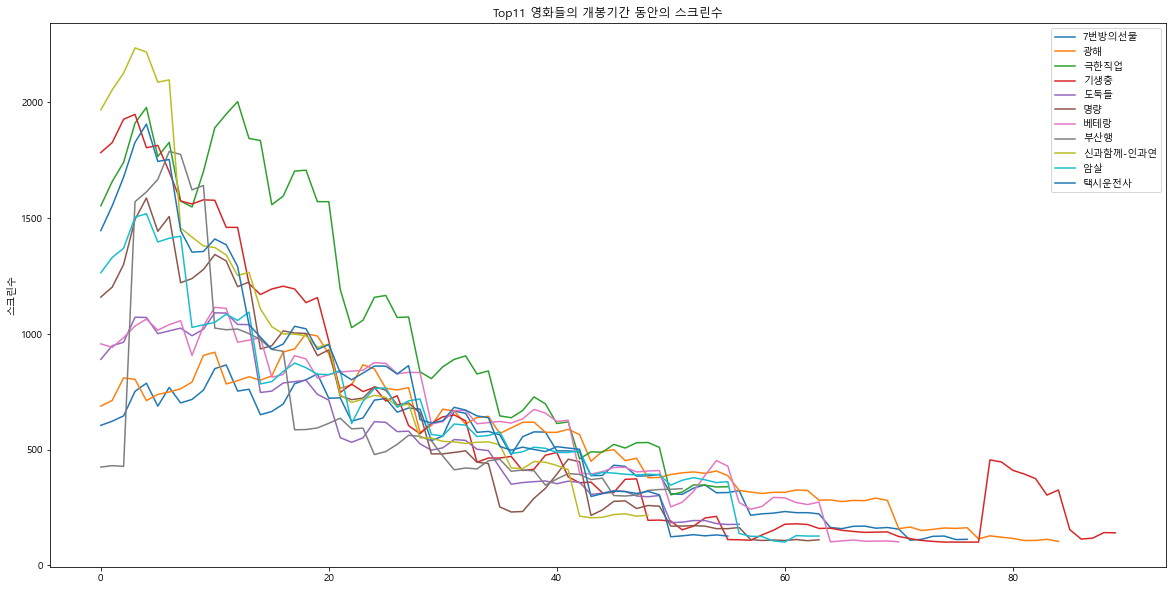

In [11]:
mf.lineplotting("스크린수")

- 부산행의 경우 개봉전 시사회 때의 스크린수가 400이상이기 때문에 개봉일 3일 전부터가 들어가 있음(제외하고 생각할 것)

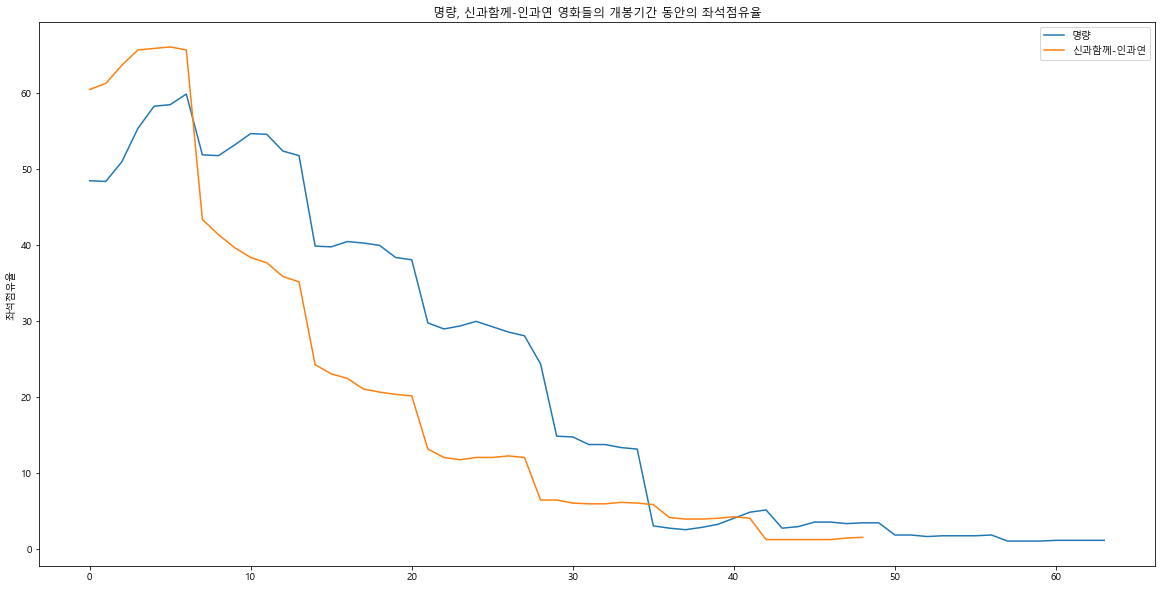

In [12]:
mf.lineplotting("좌석점유율", ["명량", "신과함께-인과연"])

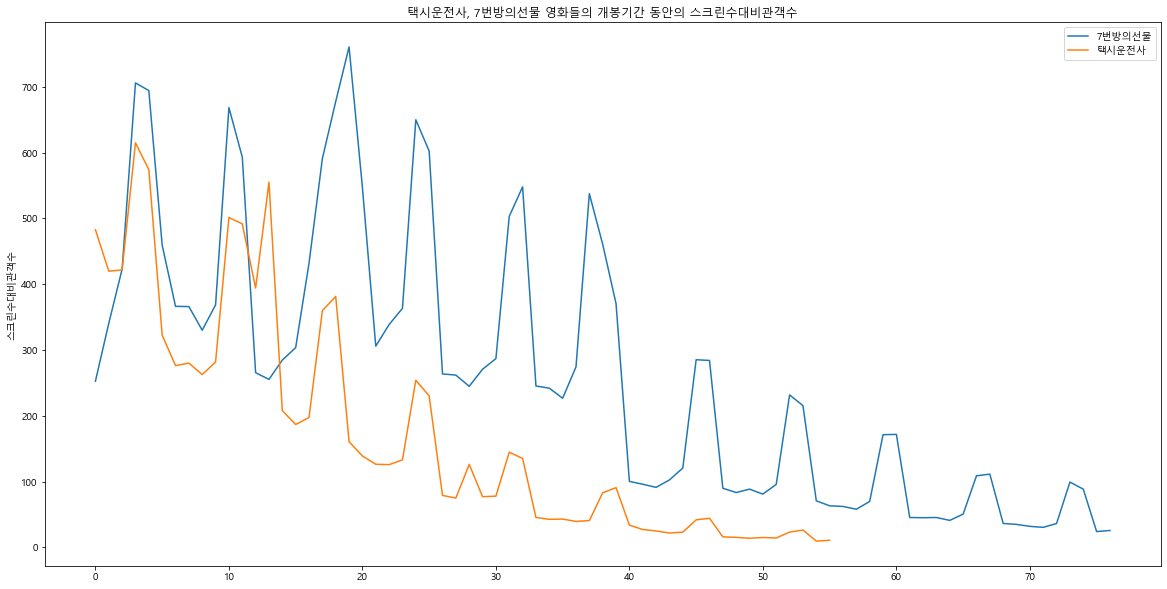

In [13]:
mf.lineplotting("스크린수대비관객수", ["택시운전사", "7번방의선물"])

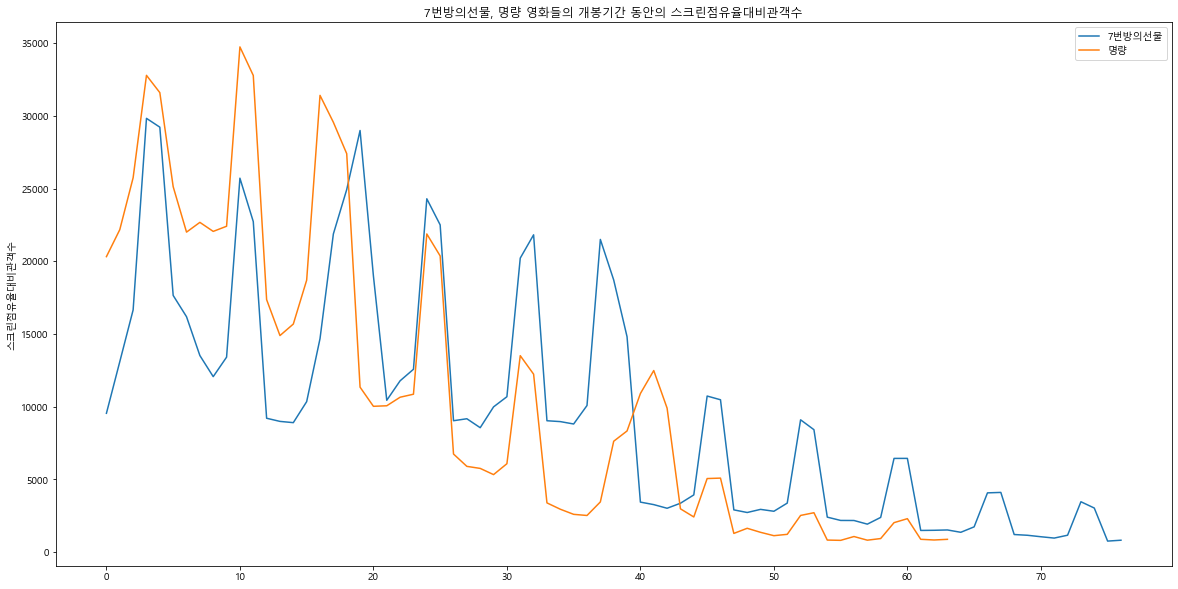

In [14]:
mf.lineplotting("스크린점유율대비관객수", ["7번방의선물", "명량"])

In [15]:
temp = []
for i in range(len(mf.movies)):
    temp.append(mf.movies[i].columns.name)
initial_screen = pd.DataFrame(temp, columns=["영화명"])

In [16]:
for i in range(len(mf.movies)):
    if mf.movies[i].columns.name == "부산행":
        initial_screen.loc[i,"초기스크린수"] = mf.movies[i].loc[3,"스크린수"]
        initial_screen.loc[i,"초기스크린점유율"] = mf.movies[i].loc[3,"스크린점유율"]
        initial_screen.loc[i,"초기좌석수"] = mf.movies[i].loc[3,"좌석수"]
        initial_screen.loc[i,"초기좌석점유율"] = mf.movies[i].loc[3,"좌석점유율"]
    else:
        initial_screen.loc[i,"초기스크린수"] = mf.movies[i].loc[0,"스크린수"]
        initial_screen.loc[i,"초기스크린점유율"] = mf.movies[i].loc[0,"스크린점유율"]
        initial_screen.loc[i,"초기좌석수"] = mf.movies[i].loc[0,"좌석수"]
        initial_screen.loc[i,"초기좌석점유율"] = mf.movies[i].loc[0,"좌석점유율"]
initial_screen.to_csv("./data/initial_screen.csv", index=False)

In [17]:
movie_info = pd.read_csv("./data/top11_movie_info.csv")
movie_info

,영화명,개봉일,관객수,스크린수,배급사,초기스크린수,초기스크린점유율,초기좌석수,초기좌석점유율,초기스크린수대비관객수,초기스크린점유율대비관객수,초기좌석수대비관객수,초기좌석점유율대비관객수
0,명량,2014-07-30,17613682,1587,(주)씨제이이엔엠,1159.0,33.6,1152173.0,48.4,15197.309750,524216.726190,15.287359,363919.049587
1,극한직업,2019-01-23,16265618,2003,(주)씨제이이엔엠,1553.0,25.4,1557839.0,53.3,10473.675467,640378.661417,10.441142,305171.069418
2,베테랑,2015-08-05,13414009,1115,(주)씨제이이엔엠,957.0,22.0,916883.0,34.8,14016.728318,609727.681818,14.630012,385460.028736
3,도둑들,2012-07-25,12983178,1091,(주)쇼박스,890.0,26.4,847704.0,40.1,14587.840449,491787.045455,15.315697,323770.024938
4,7번방의선물,2013-01-23,12811206,866,(주)넥스트엔터테인먼트월드(NEW),605.0,16.0,602838.0,27.1,21175.547107,800700.375000,21.251490,472738.228782
5,암살,2015-07-22,12705700,1519,(주)쇼박스,1264.0,28.2,1209819.0,49.0,10051.977848,450556.737589,10.502149,259300.000000
6,광해,2012-09-13,12319390,1001,(주)씨제이이엔엠,688.0,20.1,733974.0,33.3,17906.090116,612904.975124,16.784505,369951.651652
7,신과함께-인과연,2018-08-01,12274996,2235,롯데컬처웍스(주)롯데엔터테인먼트,1967.0,35.9,1742278.0,60.4,6240.465684,341921.894150,7.045372,203228.410596
8,택시운전사,2017-08-02,12186327,1906,(주)쇼박스,1446.0,27.5,1302719.0,43.8,8427.612033,443139.163636,9.354532,278226.643836
9,부산행,2016-07-20,11565479,1788,(주)넥스트엔터테인먼트월드(NEW),1571.0,33.0,1668254.0,61.3,7361.858052,350469.060606,6.932685,188670.130506


In [18]:
movie_info[["영화명", "초기스크린수"]].sort_values("초기스크린수")

,영화명,초기스크린수
4,7번방의선물,605.0
6,광해,688.0
3,도둑들,890.0
2,베테랑,957.0
0,명량,1159.0
5,암살,1264.0
8,택시운전사,1446.0
1,극한직업,1553.0
9,부산행,1571.0
10,기생충,1783.0


In [19]:
movie_info[["영화명", "초기스크린수대비관객수"]].sort_values("초기스크린수대비관객수", ascending=False)

,영화명,초기스크린수대비관객수
4,7번방의선물,21175.547107
6,광해,17906.090116
0,명량,15197.309750
3,도둑들,14587.840449
2,베테랑,14016.728318
1,극한직업,10473.675467
5,암살,10051.977848
8,택시운전사,8427.612033
9,부산행,7361.858052
7,신과함께-인과연,6240.465684


In [20]:
movie_info[["영화명", "초기스크린점유율"]].sort_values("초기스크린점유율")

,영화명,초기스크린점유율
4,7번방의선물,16.0
6,광해,20.1
2,베테랑,22.0
1,극한직업,25.4
3,도둑들,26.4
8,택시운전사,27.5
5,암살,28.2
10,기생충,31.5
9,부산행,33.0
0,명량,33.6


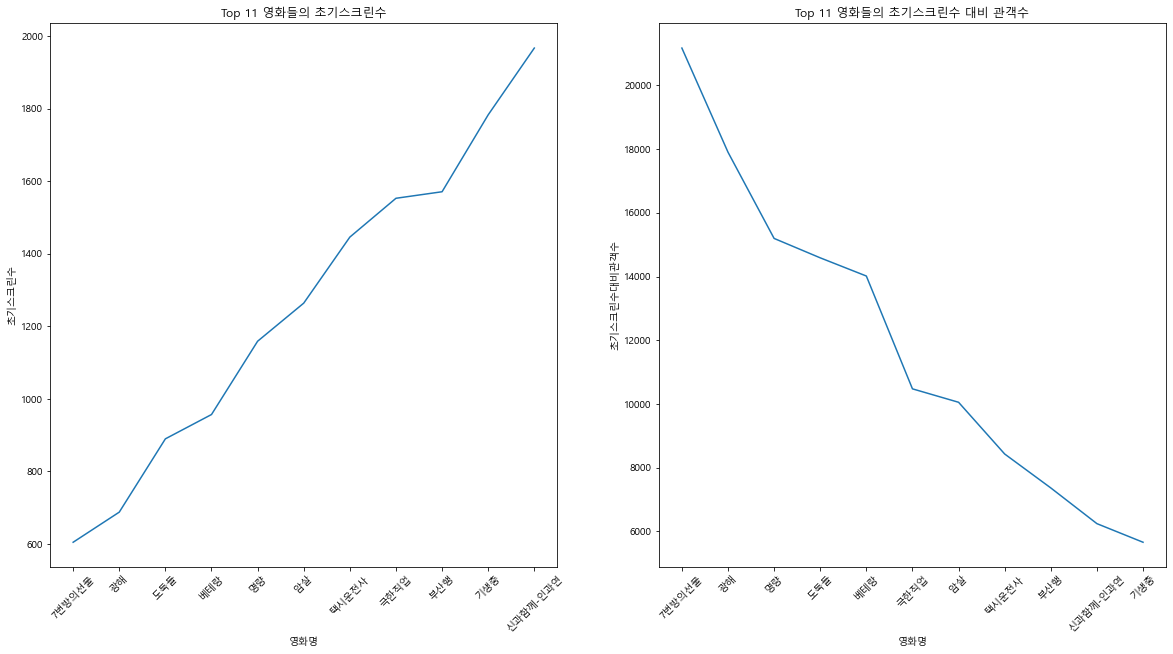

In [21]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

sns.lineplot(movie_info.sort_values("초기스크린수")["영화명"], movie_info.sort_values("초기스크린수")["초기스크린수"], ax=ax1)
sns.lineplot(movie_info.sort_values("초기스크린수대비관객수", ascending=False)["영화명"],\
     movie_info.sort_values("초기스크린수대비관객수", ascending=False)["초기스크린수대비관객수"], ax=ax2)

ax1.set_xticklabels(movie_info.sort_values("초기스크린수")["영화명"], rotation=45)
ax2.set_xticklabels(movie_info.sort_values("초기스크린수대비관객수", ascending=False)["영화명"], rotation=45)
ax1.set_title("Top 11 영화들의 초기스크린수")
ax2.set_title("Top 11 영화들의 초기스크린수 대비 관객수")

plt.savefig("./data/plot/Top11 영화들의 초기스크린수비교.jpg")
plt.show()

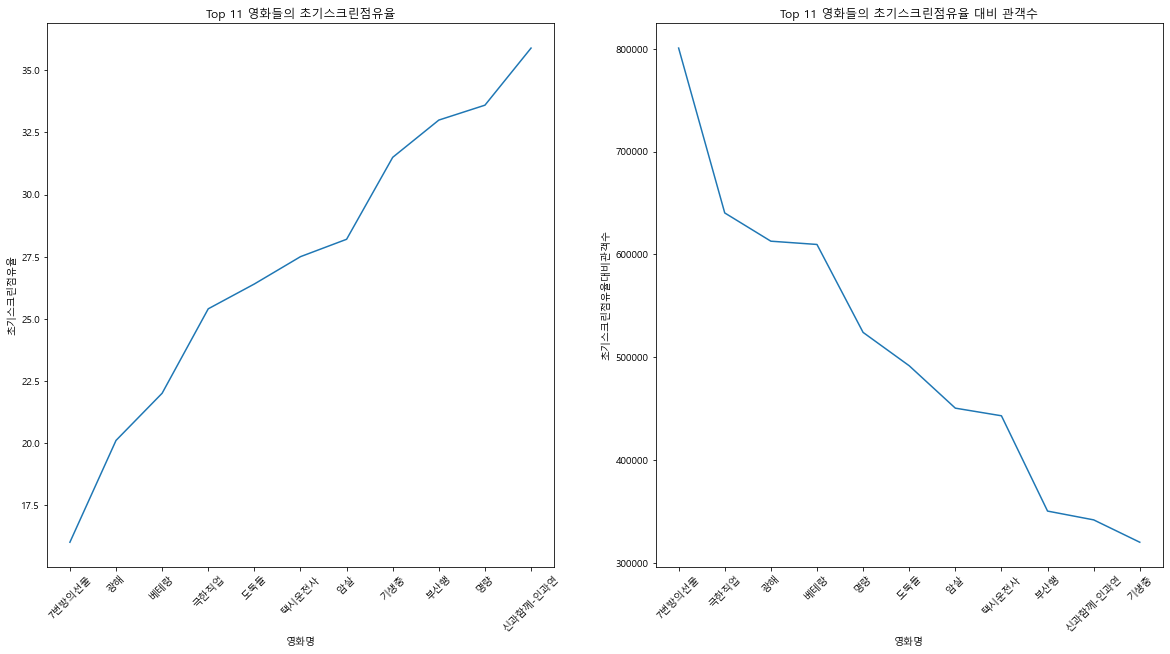

In [22]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

sns.lineplot(movie_info.sort_values("초기스크린점유율")["영화명"], movie_info.sort_values("초기스크린점유율")["초기스크린점유율"], ax=ax1)
sns.lineplot(movie_info.sort_values("초기스크린점유율대비관객수", ascending=False)["영화명"],\
     movie_info.sort_values("초기스크린점유율대비관객수", ascending=False)["초기스크린점유율대비관객수"], ax=ax2)

ax1.set_xticklabels(movie_info.sort_values("초기스크린점유율")["영화명"], rotation=45)
ax2.set_xticklabels(movie_info.sort_values("초기스크린점유율대비관객수", ascending=False)["영화명"], rotation=45)

ax1.set_title("Top 11 영화들의 초기스크린점유율")
ax2.set_title("Top 11 영화들의 초기스크린점유율 대비 관객수")

plt.savefig("./data/plot/Top11 영화들의 초기스크린점유율비교.jpg")
plt.show()

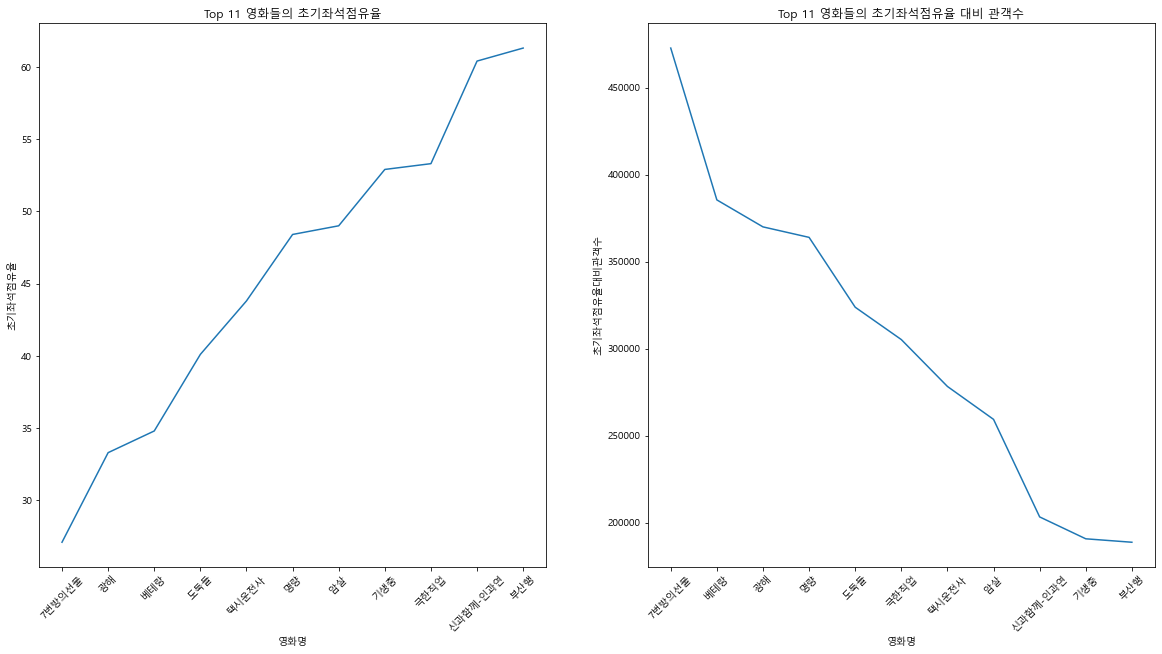

In [23]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

sns.lineplot(movie_info.sort_values("초기좌석점유율")["영화명"], movie_info.sort_values("초기좌석점유율")["초기좌석점유율"], ax=ax1)
sns.lineplot(movie_info.sort_values("초기좌석점유율대비관객수", ascending=False)["영화명"],\
     movie_info.sort_values("초기좌석점유율대비관객수", ascending=False)["초기좌석점유율대비관객수"], ax=ax2)

ax1.set_xticklabels(movie_info.sort_values("초기좌석점유율")["영화명"], rotation=45)
ax2.set_xticklabels(movie_info.sort_values("초기좌석점유율대비관객수", ascending=False)["영화명"], rotation=45)

ax1.set_title("Top 11 영화들의 초기좌석점유율")
ax2.set_title("Top 11 영화들의 초기좌석점유율 대비 관객수")

plt.savefig("./data/plot/Top11 영화들의 초기좌석점유율비교.jpg")
plt.show()

# 주제 확정 : 초기 스크린수의 혜택을 받지 못한 7번방의 선물의 흥행 요인 분석